In [2]:
import pandas as pd
import numpy as np
import os

# 🧐 Weird Water Metrics - Cleaning and Model Ready

In [6]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/cooling_boiler_df_FINAL.csv'

# Import 
cooling_boiler_df = pd.read_csv(csv_file_path)  

# Verify the import
print(cooling_boiler_df.dtypes.to_string())

/var/folders/6r/kznwmt6j1rsfwtfplchqpwj00000gn/T/ipykernel_75282/3599201801.py:5: DtypeWarning: Columns (38,58) have mixed types. Specify dtype option on import or set low_memory=False.
  cooling_boiler_df = pd.read_csv(csv_file_path)


utility_id                                int64
state                                    object
plant_code                                int64
plant_name                               object
year                                      int64
month                                     int64
generator_id                             object
boiler_id                                object
cooling_id                               object
generator_primary_technology             object
summer_cap_steam_turbines_mw            float64
gross_gen_steam_turbines_mwh            float64
net_gen_steam_turbines_mwh              float64
summer_cap_single_shaft_mw              float64
gross_gen_single_shaft_mwh              float64
net_gen_single_shaft_mwh                float64
summer_cap_combined_cycle_gt_mw         float64
gross_gen_combined_cycle_gt_mwh         float64
net_gen_combined_cycle_gt_mwh           float64
fuel_consump_all_fuel_types_mmbtu       float64
fuel_consump_steam_turbines_mmbtu       

In [21]:
print(list(cooling_boiler_df.columns))


['utility_id', 'state', 'plant_code', 'plant_name', 'year', 'month', 'generator_id', 'boiler_id', 'cooling_id', 'generator_primary_technology', 'summer_cap_steam_turbines_mw', 'gross_gen_steam_turbines_mwh', 'net_gen_steam_turbines_mwh', 'summer_cap_single_shaft_mw', 'gross_gen_single_shaft_mwh', 'net_gen_single_shaft_mwh', 'summer_cap_combined_cycle_gt_mw', 'gross_gen_combined_cycle_gt_mwh', 'net_gen_combined_cycle_gt_mwh', 'fuel_consump_all_fuel_types_mmbtu', 'fuel_consump_steam_turbines_mmbtu', 'fuel_consump_single_shaft_mmbtu', 'fuel_consump_combined_cycle_gt_mmbtu', 'coal_consumption_mmbtu', 'natural_gas_consumption_mmbtu', 'petroleum_consumption_mmbtu', 'biomass_consumption_mmbtu', 'other_gas_consumption_mmbtu', 'other_fuel_consumption_mmbtu', 'water_withdrawal_volume_mg', 'water_consumption_volume_mg', 'water_withdrawal_intensity_gal_mwh', 'water_consumption_intensity_gal_mwh', 'water_withdrawal_per_fuel_gal_mmbtu', 'water_consumption_per_fuel_gal_mmbtu', 'cooling_unit_hours_in_

In [23]:
# Specify your updated list of columns
metric_columns = [
    'summer_cap_steam_turbines_mw',
    'gross_gen_steam_turbines_mwh',
    'net_gen_steam_turbines_mwh',
    'summer_cap_single_shaft_mw',
    'gross_gen_single_shaft_mwh',
    'net_gen_single_shaft_mwh',
    'summer_cap_combined_cycle_gt_mw',
    'gross_gen_combined_cycle_gt_mwh',
    'net_gen_combined_cycle_gt_mwh',
    'fuel_consump_all_fuel_types_mmbtu',
    'fuel_consump_steam_turbines_mmbtu',
    'fuel_consump_single_shaft_mmbtu',
    'fuel_consump_combined_cycle_gt_mmbtu',
    'coal_consumption_mmbtu',
    'natural_gas_consumption_mmbtu',
    'petroleum_consumption_mmbtu',
    'biomass_consumption_mmbtu',
    'other_gas_consumption_mmbtu',
    'other_fuel_consumption_mmbtu',
    'water_withdrawal_volume_mg',
    'water_consumption_volume_mg',
    'water_withdrawal_intensity_gal_mwh',
    'water_consumption_intensity_gal_mwh',
    'water_withdrawal_per_fuel_gal_mmbtu',
    'water_consumption_per_fuel_gal_mmbtu',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake_ft'
]

# Count of missing values per selected column
missing_count = cooling_boiler_df[metric_columns].isnull().sum()

# Percentage of missing values per selected column
missing_percentage = (missing_count / len(cooling_boiler_df)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})

# Display the summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_summary.to_string())


                                      Missing Count  Missing Percentage
summer_cap_steam_turbines_mw                 306600           40.798403
gross_gen_steam_turbines_mwh                 432989           57.616633
net_gen_steam_turbines_mwh                   443757           59.049501
summer_cap_single_shaft_mw                   744768           99.104192
gross_gen_single_shaft_mwh                   746267           99.303659
net_gen_single_shaft_mwh                     746263           99.303127
summer_cap_combined_cycle_gt_mw              469644           62.494212
gross_gen_combined_cycle_gt_mwh              474969           63.202794
net_gen_combined_cycle_gt_mwh                504244           67.098337
fuel_consump_all_fuel_types_mmbtu            153223           20.388955
fuel_consump_steam_turbines_mmbtu            434164           57.772987
fuel_consump_single_shaft_mmbtu              746997           99.400798
fuel_consump_combined_cycle_gt_mmbtu         475798           63

## Excluding Derived Water Intensity Metrics

The following columns are omitted from further exploration due to overwhelming missingness (over 94%):

- `water_withdrawal_intensity_gal_mwh`
- `water_consumption_intensity_gal_mwh`
- `water_withdrawal_per_fuel_gal_mmbtu`
- `water_consumption_per_fuel_gal_mmbtu`

These values appear to be internally derived by EIA, likely calculated only when both:
- net generation data, and
- fuel consumption or water withdrawal data  
...were simultaneously available at the generator-cooling configuration level.

Given this, they do not offer consistent coverage across the dataset. For the purposes of this model, we will instead focus on **absolute water volumes** (withdrawal and consumption) as our primary targets. 

Future work could explore constructing generalized intensity metrics by fuel type or plant category, but they are not feasible for this modeling stage.


In [29]:
water_metric_columns = [
    'water_withdrawal_volume_mg',
    'water_consumption_volume_mg',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake_ft'
]

cooling_boiler_df[water_metric_columns].describe()


,water_withdrawal_volume_mg,water_consumption_volume_mg,cooling_unit_hours_in_service,avg_distance_water_intake_ft
count,495242.000000,464568.000000,572214.000000,403740.000000
mean,3304.178206,173.083879,554.302417,15.132373
std,9056.460508,1775.644217,263.715352,21.196739
min,-2.303000,-1045.000000,0.000000,0.000000
25%,23.000000,0.700000,417.000000,6.000000
50%,86.822000,25.115000,720.000000,12.000000
75%,1703.206750,77.000000,744.000000,20.000000
max,790383.000000,125728.000000,744.000000,350.000000


| Metric                          | Min Value | Suspicious? | Notes                                                                                                                     |
| ------------------------------- | --------- | ----------- | ------------------------------------------------------------------------------------------------------------------------- |
| `water_withdrawal_volume_mg`    | -2.30     | ✅ Yes       | **Water withdrawn can't be negative.** Likely data entry or system reporting error.                                       |
| `water_consumption_volume_mg`   | -1045.00  | ✅ Yes       | **Deeply negative.** That's not evaporative loss—that's the plant returning ghost water.                                  |
| `cooling_unit_hours_in_service` | 0         | ⚠️ Maybe    | Could be okay (offline that year?), but zero hours should be cross-checked with operability.                              |
| `avg_distance_water_intake_ft`  | 0         | ⚠️ Maybe    | Possibly legitimate for on-site wells or river adjacency—but worth flagging, especially with 350 ft on the other extreme. |


In [35]:
# Check for negative values in the water volume columns
negative_water = cooling_boiler_df[
    (cooling_boiler_df['water_withdrawal_volume_mg'] < 0) |
    (cooling_boiler_df['water_consumption_volume_mg'] < 0)
]

print(f"Negative water value rows: {len(negative_water)}")
display(negative_water[['plant_code', 'generator_id', 'date', 
                        'water_withdrawal_volume_mg', 'water_consumption_volume_mg']].sort_values(by='date'))


Negative water value rows: 703


,plant_code,generator_id,date,water_withdrawal_volume_mg,water_consumption_volume_mg
618264,6042,D,2016-01-01,35023.338,-0.008
618924,6043,8A,2016-01-01,21656.621,-28.350
618960,6043,8D,2016-01-01,21656.621,-28.350
618132,6042,C,2016-01-01,35023.338,-0.008
618144,6042,D,2016-01-01,35023.338,-0.008
...,...,...,...,...,...
7017,710,5ACT,2023-10-01,0.012,-1045.000
7005,710,5,2023-10-01,0.012,-1045.000
19797,2723,ST7,2023-10-01,1.800,-0.300
19761,2723,ST7,2023-10-01,1.800,-0.300


## Explore in pgAdmin / PostgreSQL
- VIEW: cooling_boiler_negative_water_metrics

```
CREATE OR REPLACE VIEW cooling_boiler_negative_water_metrics AS
    SELECT *
    FROM cooling_boiler_df
    WHERE water_withdrawal_volume_mg < 0
       OR water_consumption_volume_mg < 0
       OR water_withdrawal_intensity_gal_mwh < 0
       OR water_consumption_intensity_gal_mwh < 0
       OR water_withdrawal_per_fuel_gal_mmbtu < 0
       OR water_consumption_per_fuel_gal_mmbtu < 0; 
```
- VIEW: all_rows_from_plants_with_negative_water_metrics

```
CREATE OR REPLACE VIEW all_rows_from_plants_with_negative_water_metrics AS
SELECT *
FROM cooling_boiler_df
WHERE plant_code IN (
    SELECT DISTINCT plant_code
    FROM cooling_boiler_negative_water_metrics
);
```
- VIEW: negative_water_summary_by_year

```
CREATE VIEW negative_water_summary_by_year AS
SELECT
    year,
    plant_code,
    steam_plant_type_full,
    cooling_system_signature_full,
    gen_tech_signature,
    configuration_type,
    cooling_design_signature,
    SUM(water_withdrawal_volume_mg) AS total_water_withdrawal_mg,
    SUM(water_consumption_volume_mg) AS total_water_consumption_mg
FROM all_rows_from_plants_with_negative_water_metrics
GROUP BY
    year,
    plant_code,
    steam_plant_type_full,
    cooling_system_signature_full,
    gen_tech_signature,
    configuration_type,
    cooling_design_signature
ORDER BY
    plant_code,
    year DESC;
```

### Notes: 
- 40 plants with negative water metrics
- Breakdown by year: 

| Year | Plant Code | # Rows with Negative Water Metrics |
|------|------------|-----------------------------------|
| 2023 | 676        | 2                                 |
| 2023 | 710        | 6                                 |
| 2023 | 1082       | 1                                 |
| 2023 | 2723       | 6                                 |
| 2023 | 3443       | 4                                 |
| 2023 | 4078       | 3                                 |
| 2023 | 7846       | 6                                 |
| 2022 | 4078       | 1                                 |
| 2022 | 6081       | 24                                |
| 2022 | 6639       | 6                                 |
| 2022 | 55183      | 4                                 |
| 2022 | 57028      | 2                                 |
| 2021 | 602        | 2                                 |
| 2021 | 728        | 2                                 |
| 2021 | 3611       | 2                                 |
| 2021 | 3943       | 4                                 |
| 2021 | 6019       | 4                                 |
| 2021 | 7097       | 2                                 |
| 2021 | 7512       | 6                                 |
| 2021 | 8068       | 4                                 |
| 2021 | 55047      | 2                                 |
| 2020 | 602        | 2                                 |
| 2020 | 676        | 4                                 |
| 2020 | 6019       | 1                                 |
| 2020 | 55132      | 12                                |
| 2020 | 55333      | 12                                |
| 2020 | 55708      | 5                                 |
| 2019 | 602        | 1                                 |
| 2019 | 676        | 2                                 |
| 2019 | 3612       | 9                                 |
| 2019 | 6019       | 2                                 |
| 2019 | 7153       | 12                                |
| 2019 | 7213       | 8                                 |
| 2019 | 7512       | 18                                |
| 2019 | 8222       | 3                                 |
| 2019 | 55708      | 4                                 |
| 2018 | 1242       | 8                                 |
| 2018 | 1252       | 9                                 |
| 2018 | 2393       | 100                               |
| 2018 | 55334      | 6                                 |
| 2018 | 55393      | 12                                |
| 2017 | 676        | 6                                 |
| 2017 | 6081       | 12                                |
| 2017 | 10682      | 8                                 |
| 2017 | 55328      | 6                                 |
| 2017 | 55411      | 6                                 |
| 2017 | 58503      | 2                                 |
| 2016 | 60         | 1                                 |
| 2016 | 602        | 1                                 |
| 2016 | 676        | 9                                 |
| 2016 | 6019       | 3                                 |
| 2016 | 6042       | 22                                |
| 2016 | 6043       | 280                               |
| 2016 | 55524      | 24                                |

## **Analysis**

- **Distribution:**  
  The number of rows with negative water metrics varies widely by plant and year; some plants (e.g., plant 6043 in 2016 with 280 rows, plant 2393 in 2018 with 100 rows) are clear outliers with much higher counts than others.
- **Recurrent Plants:**  
  Certain plant codes (e.g., 676, 602, 6019, 7512, 55708) appear in multiple years, suggesting persistent or recurring negative water metric issues at these facilities.
- **Temporal Trends:**  
  No clear year-over-year trend is visible from this excerpt alone, but specific years (e.g., 2016, 2018, 2019, 2020) show some plants with notably high counts, possibly indicating episodic data or operational issues.
- **Focus for Investigation:**  
  Plants with the highest counts and those recurring across years may warrant further operational review or data quality checks.

## **Furthermore**

When aggregated to annual summaries, no plant shows negative water withdrawal values. However, 10 rows from 4 distinct plants still report negative water consumption values. This suggests that negative water metrics are localized anomalies that disappear when data is rolled up, and that understanding their patterns will require a closer look at monthly records.

To support this, we create a flag column to identify all rows associated with any plant_code that has ever reported negative water metrics. This will allow for targeted visualizations and analyses of these plants’ month-by-month trajectories and operational patterns.

**This approach is not only a data cleaning strategy, but also a means of surfacing potentially systemic reporting irregularities that may affect interpretability of modeled outcomes.**

In [163]:
# Step 1: Identify rows with negative water withdrawal or consumption
negative_rows = cooling_boiler_df[
    (cooling_boiler_df['water_withdrawal_volume_mg'] < 0) |
    (cooling_boiler_df['water_consumption_volume_mg'] < 0)
]

# Step 2: Extract unique plant_codes from those rows
plants_with_negatives = negative_rows['plant_code'].unique()

# Step 3: Create two flag columns in the original dataframe

# Plant-level flag
cooling_boiler_df['flag_plant_has_negative'] = cooling_boiler_df['plant_code'].isin(plants_with_negatives).astype(int)

# Row-level flag
cooling_boiler_df['flag_row_is_negative'] = (
    (cooling_boiler_df['water_withdrawal_volume_mg'] < 0) |
    (cooling_boiler_df['water_consumption_volume_mg'] < 0)
).astype(int)


In [165]:
cooling_boiler_df['flag_row_is_negative'].value_counts()

flag_row_is_negative
0    750797
1       703
Name: count, dtype: int64

In [167]:
cooling_boiler_df['flag_plant_has_negative'].value_counts()


flag_plant_has_negative
0    714084
1     37416
Name: count, dtype: int64

python(79664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


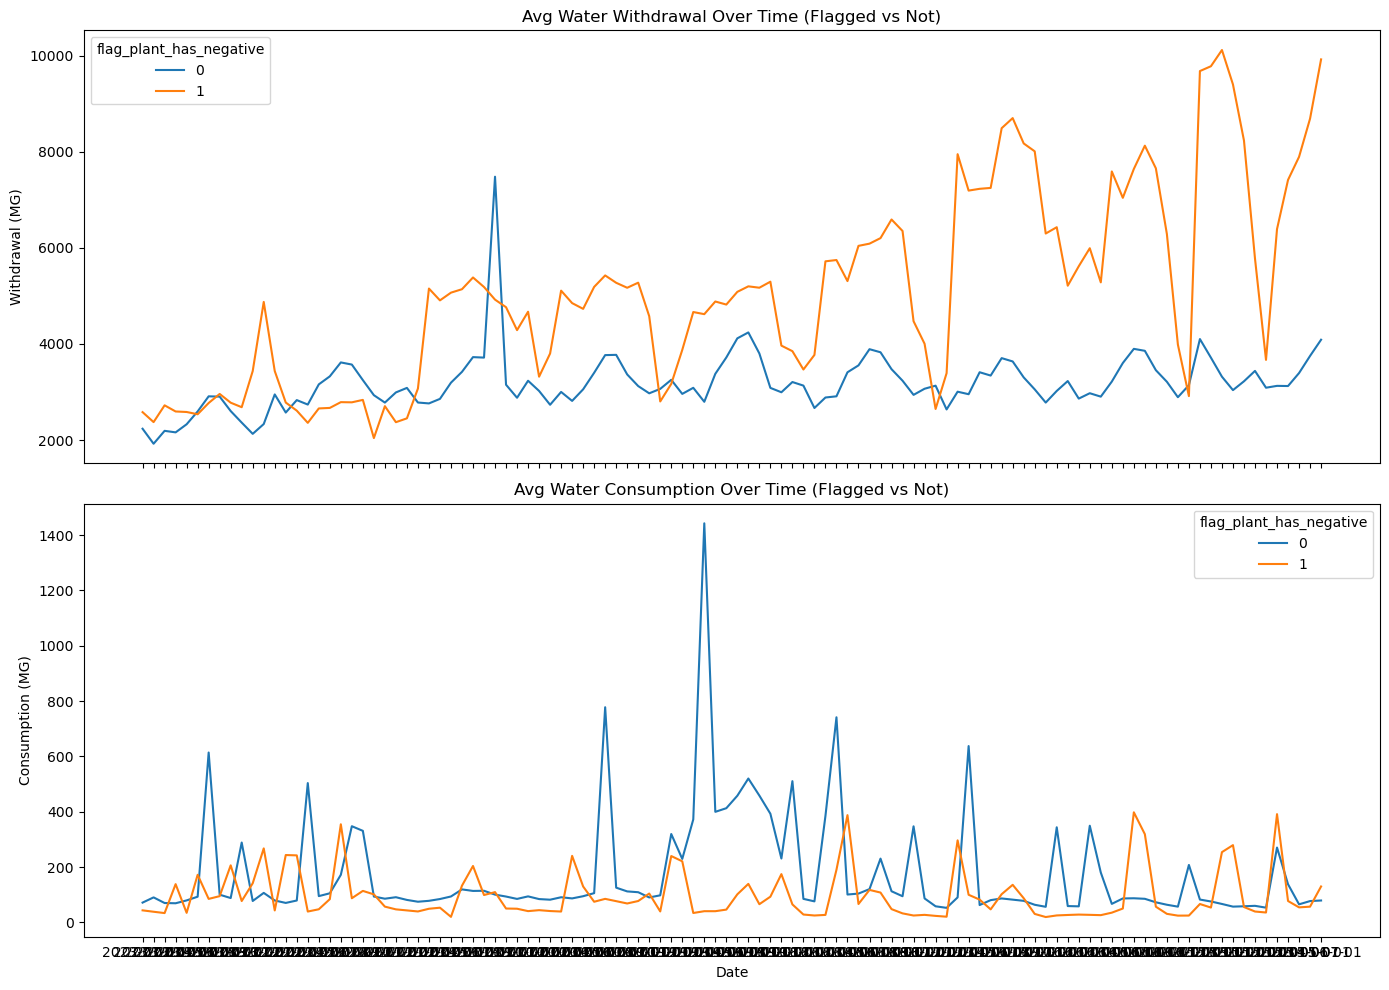

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot average water values over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.lineplot(
    data=cooling_boiler_df,
    x='date',
    y='water_withdrawal_volume_mg',
    hue='flag_plant_has_negative',
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Avg Water Withdrawal Over Time (Flagged vs Not)')
ax[0].set_ylabel('Withdrawal (MG)')

sns.lineplot(
    data=cooling_boiler_df,
    x='date',
    y='water_consumption_volume_mg',
    hue='flag_plant_has_negative',
    estimator='mean',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Avg Water Consumption Over Time (Flagged vs Not)')
ax[1].set_ylabel('Consumption (MG)')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [66]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/suswatermetrics_flag_plant_has_neg.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/suswatermetrics_flag_plant_has_neg.png


## Patterns in Flagged vs. Unflagged Plants

The first visualization—comparing average monthly withdrawal and consumption between flagged and unflagged plants—suggests striking behavioral differences:

### Withdrawal Patterns
- **Flagged plants** exhibit autocorrelated and **non-stationary** withdrawal behavior, with a clear upward trend and pronounced volatility over time.
- In contrast, **unflagged plants** show relatively **stationary** withdrawal behavior, with lower and more stable values overall, aside from a notable spike in an earlier period.

### Consumption Patterns
- **Flagged plants** display consistently **lower** water consumption, with fewer and smaller spikes compared to unflagged plants.
- In many months, flagged plants' consumption appears to move **in counterpoint** to that of unflagged plants—spiking when others are flat, and
dipping during periods of broader activity.

Thanks for sharing the graph directly—now we can scrutinize its jagged rhythms and tease apart the visual evidence of our hypothesis.

### Quick Recap

1. **Top Plot: Avg Water Withdrawal (MG) Over Time**

   * **Orange (flag = 1)** shows a clear **non-stationary upward trend**, particularly accelerating after mid-2016.
   * **Blue (flag = 0)** hovers consistently lower, without a clear trend—more **stationary**, with just a few early spikes.

2. **Bottom Plot: Avg Water Consumption (MG) Over Time**

   * **Blue (flag = 0)** is more volatile, with tall, irregular spikes—possibly reflecting periods of high consumption.
   * **Orange (flag = 1)** stays low throughout, with small ripples and few sharp peaks.

#### 🔶 Withdrawal Patterns (Top)

* **The volatility in flagged plants is visually dramatic**—clearly not just "noise." The high peaks and widening spread in the orange line make a compelling case for either:

  * Structural difference in cooling system design,
  * Or misclassification/error in how withdrawal is recorded or defined.
* The **sharp upward trajectory** toward the right end suggests:

  * Either growing reporting errors,
  * Or an increase in flagged plant activity (e.g., addition of large once-through systems or changes in reporting conventions post-2018–2020?).

#### 🔷 Consumption Patterns (Bottom)

  * **Flagged plants (orange)** barely register consumption. It’s not just “lower on average”—it’s **practically absent.**
  * The blue line (unflagged) shows **intermittent spikes**—suggesting variable but real water use.
* The **decoupling between withdrawal and consumption** for flagged plants is now undeniably odd:

  * High withdrawal **should** correlate to at least some consumption unless water is 100% returned—possible in once-through systems but *still* suspect if uncorroborated by system metadata.

---

### What This Graph Strongly Supports

✅ **Water withdrawal ≠ water consumption**, especially for flagged plants—and that discrepancy is *highly structured over time*, not random.

✅ The flagged group's behavior might be influencing **overall water metrics in aggregate national stats**, particularly as the withdrawal line dominates more in later years.

---

### Possible Interpretations
- **High withdrawal but low consumption** might make sense for:
  - **Larger thermal combustion** or **non-combustion plants** using **once-through cooling systems**, where most of the withdrawn water is returned.
- However:
  - For **non-steam plants**, we would typically **not expect water metrics** at all.
  - For **recirculating systems**, such high withdrawal volumes **without corresponding consumption** would be unusual and likely indicative of a reporting anomaly or operational irregularity.

These diverging patterns underscore the value of the flagging approach, as they highlight a subset of plants whose reporting or operations may diverge meaningfully from typical thermal plant behavior. They also raise deeper questions about instrumentation, system design, and regulatory reporting.


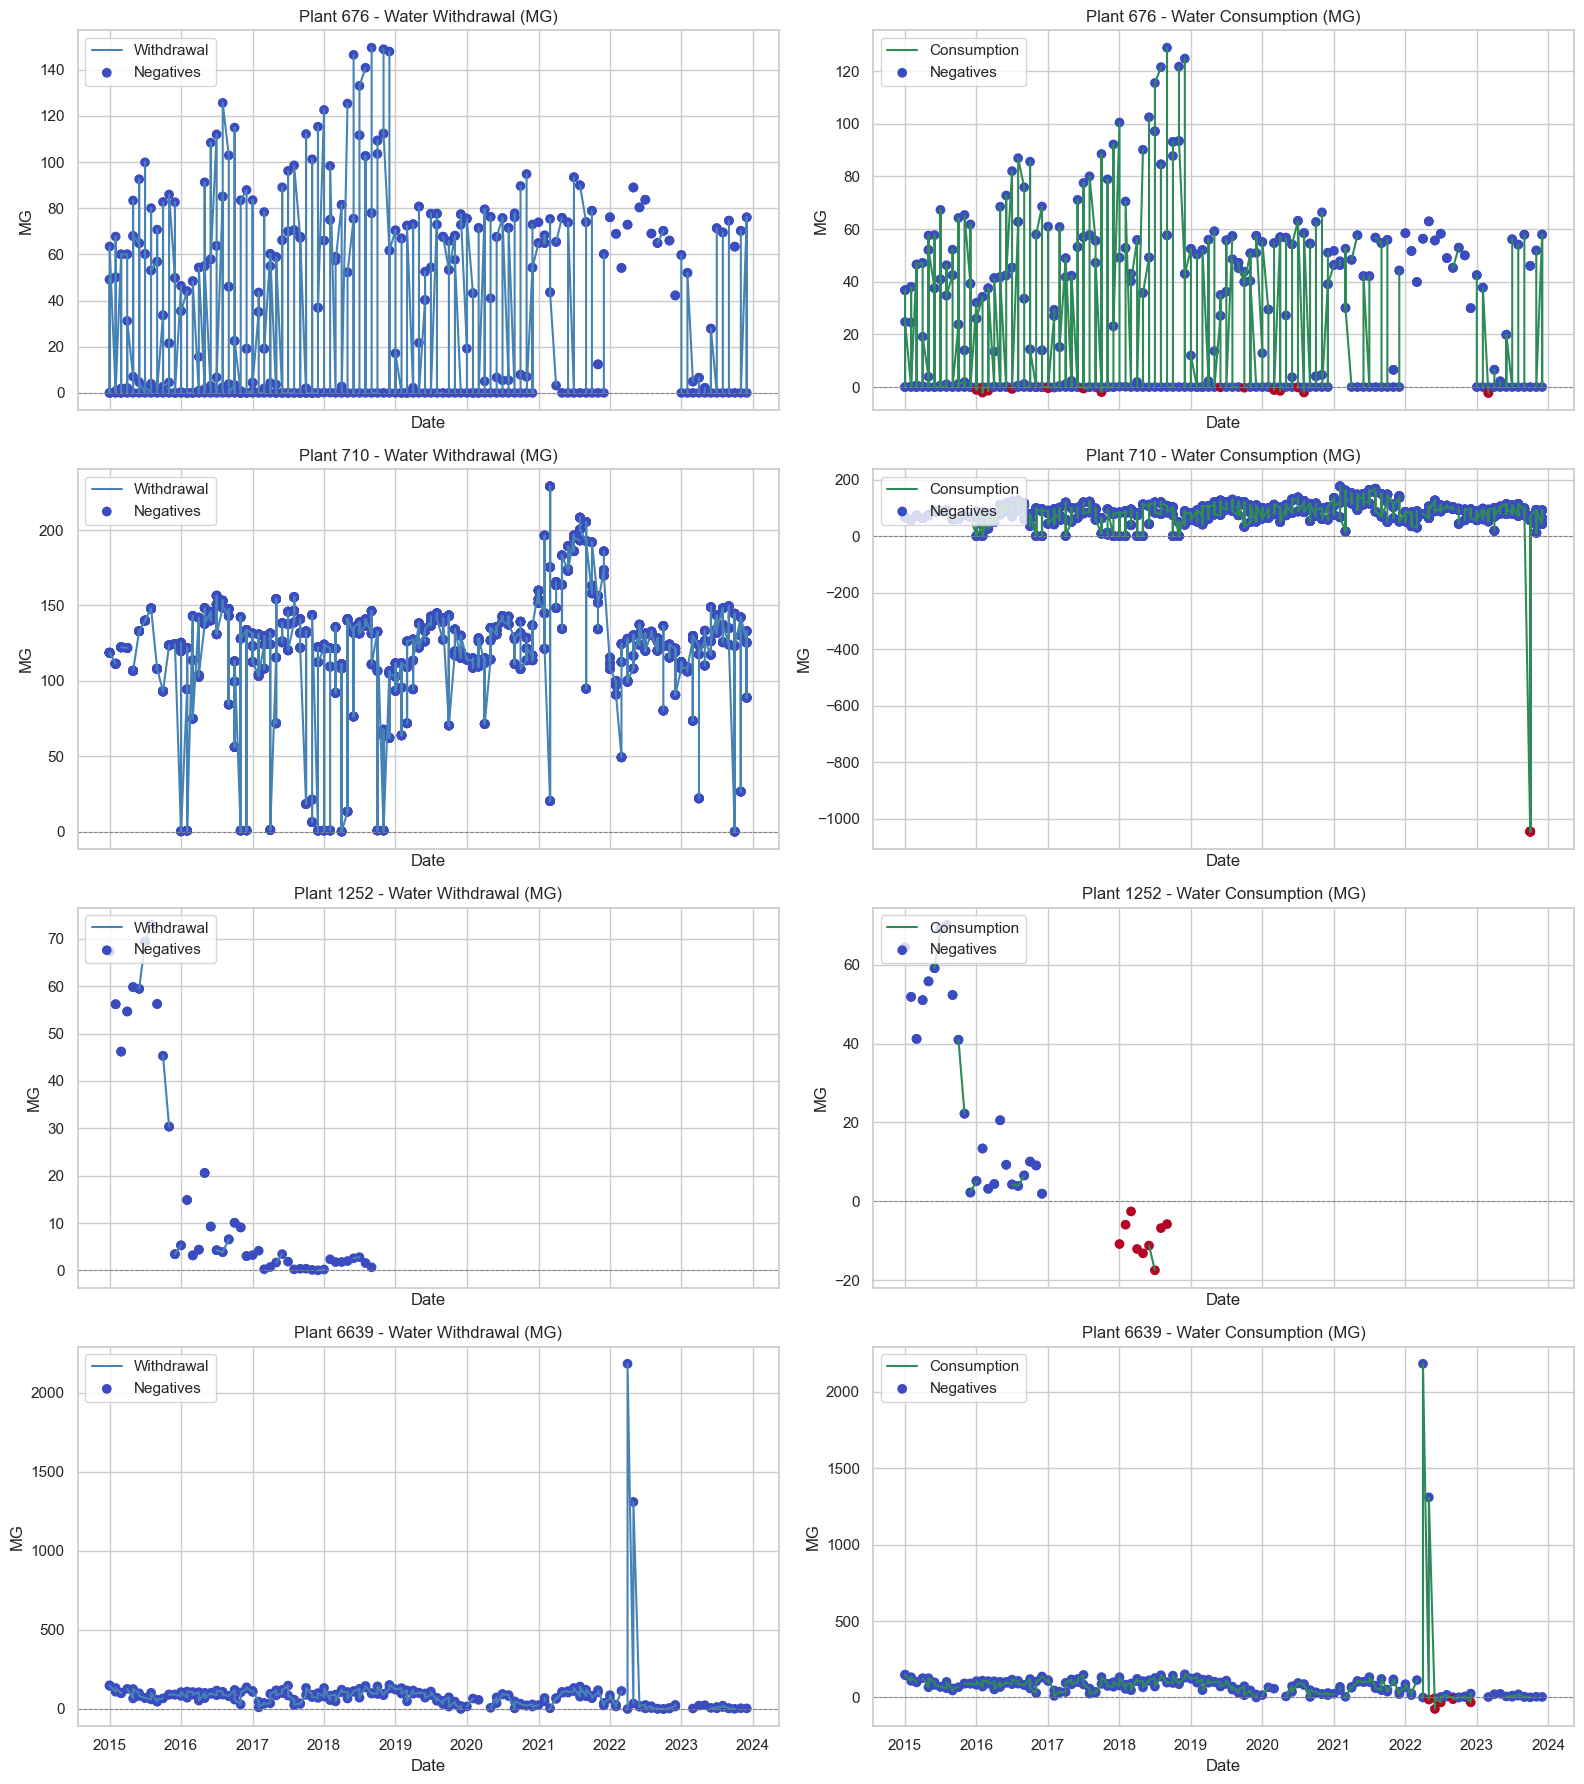

In [69]:
# --- Subset for specific plants ---
anomalous_plants = [676, 710, 1252, 6639]
df_anomalous = cooling_boiler_df[cooling_boiler_df['plant_code'].isin(anomalous_plants)].copy()

# --- Convert to datetime if not already ---
df_anomalous['date'] = pd.to_datetime(df_anomalous[['year', 'month']].assign(day=1))

# --- Plot setup ---
sns.set(style="whitegrid")
fig1, axes = plt.subplots(4, 2, figsize=(16, 18), sharex=True)

for i, plant in enumerate(anomalous_plants):
    plant_df = df_anomalous[df_anomalous['plant_code'] == plant].sort_values('date')
    
    # Plot Withdrawal
    axes[i, 0].plot(plant_df['date'], plant_df['water_withdrawal_volume_mg'], label='Withdrawal', color='steelblue')
    axes[i, 0].scatter(plant_df['date'], plant_df['water_withdrawal_volume_mg'], 
                      c=(plant_df['water_withdrawal_volume_mg'] < 0), cmap='coolwarm', label='Negatives')
    axes[i, 0].set_title(f"Plant {plant} - Water Withdrawal (MG)")
    axes[i, 0].axhline(0, linestyle='--', color='gray', linewidth=0.7)

    # Plot Consumption
    axes[i, 1].plot(plant_df['date'], plant_df['water_consumption_volume_mg'], label='Consumption', color='seagreen')
    axes[i, 1].scatter(plant_df['date'], plant_df['water_consumption_volume_mg'], 
                      c=(plant_df['water_consumption_volume_mg'] < 0), cmap='coolwarm', label='Negatives')
    axes[i, 1].set_title(f"Plant {plant} - Water Consumption (MG)")
    axes[i, 1].axhline(0, linestyle='--', color='gray', linewidth=0.7)

# Final layout
for ax in axes.flatten():
    ax.legend(loc='upper left')
    ax.set_ylabel('MG')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()


In [72]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/suswatermetrics_plants_neg_consumption.png'
fig1.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/suswatermetrics_plants_neg_consumption.png


## Observations on Anomalous Plants
AZ+ChatGPT

Plants 676 and 6639 raise flags not only due to the presence of negative water metrics, but because their withdrawal and consumption values are nearly identical across time—suggesting that the same numbers were systematically entered for both fields. This implies a water efficiency ratio of 1, which is highly improbable for thermal plants and likely indicates either a reporting shortcut or an error in data processing.

Plant 710, by contrast, displays a more expected relationship between withdrawal and consumption, with the latter being consistently lower. However, it includes a single, extreme outlier: a water consumption value below -1000 MG—the lowest in the entire dataset. While this appears to be a clear data entry error, it would be prudent to check generator or cooling system operational status during that month to rule out equipment malfunction.

Plant 1252, the only Medium Thermal Combustion plant in this group (compared to the others, which are all Large Thermal Combustion), shows a different pattern: its data points are scattered and non-consecutive, making the time series discontinuous. These cluster patterns reflect intermittent operation. A closer inspection confirms this: Plant 1252 (Tecumseh, Kansas – Conventional Coal) demonstrates a history of sporadic unavailability.

## **Review of Your Observations** 
(Perplexity AI)

### **Plants 676 and 6639**
- **Your Take:**  
  Withdrawal and consumption values are nearly identical over time, suggesting a water efficiency ratio of 1-highly improbable for thermal plants. Likely a reporting shortcut or data processing error.
- **Additional Insight:**  
  This kind of “mirroring” is a classic sign that either (a) consumption was auto-filled to match withdrawal, or (b) both fields were derived from a single source or calculation, rather than measured independently.  
  - **Efficiency ratios** in real-world thermal plants are almost never exactly 1 due to losses (evaporation, blowdown, drift, leaks).
  - The rare spikes (especially the huge outlier in Plant 6639) further suggest either a unit conversion error or a one-off data entry problem.

### **Plant 710**
- **Your Take:**  
  Generally expected relationship between withdrawal and consumption, but with a single, extreme negative outlier in consumption (below -1000 MG). Suggests a data entry error, but operational review is warranted.
- **Additional Insight:**  
  That single extreme negative value is a textbook candidate for data validation rules (e.g., flag any value < 0 or outside plausible operational bounds).  
  - If operational logs show no corresponding anomaly, this can be confidently attributed to a reporting or transcription error.
  - If there was a system failure or maintenance event, it’s worth documenting as a real anomaly.

### **Plant 1252**
- **Your Take:**  
  Discontinuous, clustered data points reflect intermittent operation. Plant is a Medium Thermal Combustion unit with a history of sporadic unavailability.
- **Additional Insight:**  
  The scatter and gaps are consistent with a plant that only operates seasonally or as a backup/peaking unit.  
  - The presence of negative consumption values (red dots) in some clusters suggests either reporting confusion during startup/shutdown periods or errors in measurement when the plant is offline.
  - This plant’s operational logs would likely confirm periods of inactivity.

---

## **General Patterns Noted in the Plots**

- **Negative Values:**  
  Clearly marked and easy to spot-excellent for quick QA.
- **Spikes:**  
  Large, isolated spikes (especially in Plant 6639) are almost always data errors, unless corroborated by operational events.
- **Parallel Trends:**  
  Identical withdrawal and consumption lines should always be investigated-true parallelism is rare in physical systems.

---

## **Recommendations & Next Steps**

1. **Automate Flagging:**  
   - Build rules to flag plants where withdrawal and consumption are always (or almost always) identical.
   - Flag any negative values or implausible spikes for review.

2. **Operational Cross-Check:**  
   - For extreme outliers (like Plant 710’s -1000 MG), check maintenance logs, operational notes, and SCADA data for corroboration.

3. **Data Correction:**  
   - Where errors are confirmed, correct or exclude these values from analyses that inform reporting or regulatory submissions.

4. **Communicate with Data Providers:**  
   - Share these findings with plant operators or data entry teams-systematic issues (like copy-paste errors) may be fixed at the source.

5. **Document Data Issues:**  
   - Keep a log of plants and periods with confirmed data quality issues for transparency and future audits.

---

## **Summary Table**

| Plant  | Pattern/Anomaly                  | Likely Cause                 | Action Needed                    |
|--------|----------------------------------|------------------------------|----------------------------------|
| 676    | Withdrawal ≈ Consumption         | Reporting or processing error| Flag & review data entry process |
| 6639   | Withdrawal ≈ Consumption, spikes | Reporting or processing error| Flag & review data entry process |
| 710    | Extreme negative consumption     | Data entry or system error   | Check logs, correct if needed    |
| 1252   | Discontinuous, scattered points  | Intermittent operation       | Confirm with ops, flag negatives |

---
Answer from Perplexity: pplx.ai/share

# SQL

```
SELECT 
  steam_plant_type_full,
  configuration_type,
  cooling_design_signature,
  COUNT(*) AS row_count
FROM cooling_boiler_negative_water_metrics
GROUP BY 
  steam_plant_type_full, 
  configuration_type, 
  cooling_design_signature;
```

| Steam Plant Type                                   | Configuration Type | Cooling Design Signature                        | Row Count |
|----------------------------------------------------|--------------------|-------------------------------------------------|-----------|
| Large Non-Combustion Steam Plants (≥100 MW)        | 1C 1B MG           | (RI) Recirculate: Induced Draft \| MISSING      | 4         |
| Large Non-Combustion Steam Plants (≥100 MW)        | 1C MB MG           | (RI) Recirculate: Induced Draft \| MISSING      | 160       |
| Large Non-Combustion Steam Plants (≥100 MW)        | Complex            | (RI) Recirculate: Induced Draft \| MISSING      | 12        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | 1C 1B MG           | (RI) Recirculate: Induced Draft \| MISSING      | 16        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | 1C MB MG           | (RC) Recirculate: Cooling Pond \| MISSING       | 46        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | 1C MB MG           | (RI) Recirculate: Induced Draft \| MISSING      | 76        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Complex            | (RI) Recirculate: Induced Draft \| MISSING      | 6         |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Complex            | MISSING \| MISSING                              | 292       |
| Large Thermal Combustion Steam Plants (≥100 MW)    | MC 1B MG           | (RI) Recirculate: Induced Draft \| MISSING      | 2         |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Simple             | (RC) Recirculate: Cooling Pond \| MISSING       | 13        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Simple             | (RI) Recirculate: Induced Draft \| MISSING      | 47        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Simple             | (RN) Recirculate: Natural Draft \| MISSING      | 14        |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Unoperable         | (RI) Recirculate: Induced Draft \| MISSING      | 2         |
| Large Thermal Combustion Steam Plants (≥100 MW)    | Unoperable         | MISSING \| MISSING                              | 4         |
| Medium Thermal Combustion Steam Plants (10–99 MW)  | Simple             | (RI) Recirculate: Induced Draft \| MISSING      | 9         |


## Key Findings on Negative Water Metrics in Power Plant Data

- **Large Thermal Combustion Steam Plants** (traditional fossil fuel plants) contribute the majority of suspect negative water metric values.
- The **MISSING \| MISSING** cooling design signature is highly overrepresented among rows with negative water metrics, indicating data quality or reporting gaps.
- **Configuration types** labeled as “Complex” and “1C” (linked to multiple boilers and generators) are common among problematic records.
- All these flagged rows are associated with **closed (recirculating) cooling systems** where information is available. **Recirculating cooling systems** should consume more water than they withdraw.

---

## 🎯 Predictive Model Goal

> **Predict monthly or annual water withdrawal and/or consumption based on plant features.**

### Candidate Features:

* Steam Plant Type
* Configuration Type
* Cooling Design Signature
* Generator Age or Capacity 
* Operational Status
* Fuel Type

### Labels:

* Withdrawal (MG)
* Consumption (MG)

---

## ⚖️ Assessing Bias from Removing Bad Data

| Removal Option                          | Rows Removed       | Pros                               | Cons                                                             |
| --------------------------------------- | ------------------ | ---------------------------------- | ---------------------------------------------------------------- |
| Remove **all 40 plants**                | 37,416 rows (\~5%) | Fully eliminates suspect reporting | May remove entire legitimate classes (e.g. large non-combustion) |
| Remove **only the 703 neg-metric rows** | 703 rows (<0.1%)   | Preserves more data                | Leaves problematic plants with partial histories                 |
| Impute or flag                          | 703+ rows          | Maximizes data retention           | Adds complexity and possible model noise                         |

🧪 **Suggestion:**
Try both a conservative version (**703-row removal**) and an aggressive one (**40-plant removal**) to **compare model robustness**.

---

## 🔍 Model of Missingness

You asked:

> "Can we create a model of missingness, based on Large Thermal Combustion plants with complex/missing configurations and closed cooling systems?"

Yes—and here's how:

### 🔮 Predicting Risk of Missing/Anomalous Water Metrics

We can formulate it as:

> **“Given plant configuration and design, what’s the probability a row has missing or anomalous water values?”**

### Labels:

* Binary: `has_anomaly = 1 if withdrawal < 0 or consumption < 0 or missing, else 0`

### Features:

* Steam Plant Type
* Configuration Type
* Cooling Design Signature
* Fuel Type (if available)
* Operating Status
* Generator Age
* Month/Year (to assess system-wide patterns)

This **meta-model** could help:

* Flag high-risk configurations for **data quality review**,
* Serve as a **pre-processing filter** in your predictive pipeline,
* Feed into **Edge AI logic**—e.g., “if anomaly probability > 0.7, escalate to operator.”

---

## 🌱 Bonus Insight

> Many of your flagged plants use **recirculating systems** but still report **low or negative consumption**.

This *may point to misinterpretation of definitions* in reporting (e.g., confusing “withdrawal” with “makeup water”)—or it may indicate system malfunctions. Either way, this reinforces your hypothesis that **system design + plant type + configuration are deeply predictive of data quality and water behavior**.

---


---

## ✅ Two Interlocking Goals

### 1. **Predictive Water Use Model**

* **Goal:** Estimate *expected* withdrawal/consumption from plant design and status.
* **Eventually usable for:** Planning, regulation, monitoring, Edge AI decision support.

### 2. **Missingness / Anomaly Model**

* **Goal:** Identify which records are likely erroneous, incomplete, or implausible.
* **Eventually usable for:** Preprocessing filters, audit prioritization, warning flags in edge deployments.

---

## 🧰 Implementation Strategy

1. **Generate all row-level flags** as Boolean columns in your Pandas pipeline.
2. Use those to build a **master `anomaly_flag`** column.
3. Create a version of your dataset with only `anomaly_flag == False` → this becomes your **clean set**.
4. Then:

   * Use the flagged set to **train a classifier** (`anomaly_flag` as target),
   * Use the clean set to **train your regression/prediction model**.

---

## 🌟 Bonus Suggestion: Create a Metadata Dashboard

Use Tableau or a quick Python summary (e.g., `df.groupby(...).agg(...)`) to track:

* % of flagged rows by plant type
* Which cooling designs are most likely to be anomalous
* Most common anomalies per year

This could even evolve into a **Data Quality Report** embedded in your final presentation or Edge AI design doc.

---

# Flag List 

| Feature Name                 | Use? | Comment                                  |
| ---------------------------- | ---- | ---------------------------------------- |
| `cooling_type_mismatch`      | ✅    | Direct input — configuration mismatch    |
| `unknown_cooling_with_water` | ✅    | Logical contradiction                    |
| `flag_row_is_negative`       | ✅    | Row-level anomaly                        |
| `zero_withdraw_and_consume`  | ✅    | Potential underreporting                 |
| `copycat_flag`               | ✅    | Possible duplication, non-reporting      |
| `flag_unoperable_with_water` | ✅    | Retired system w/ water use = suspicious |
| `flag_plant_has_negative`    | 🔶   | Maybe use as a weight or context column  |


In [93]:
cooling_boiler_df['generator_fuel_type'].value_counts(dropna=False)

generator_fuel_type
(NG) Natural Gas                                                   514044
(BIT) Bituminous Coal                                               98784
(SUB) Subbituminous Coal                                            55260
(BLQ) Black Liquor                                                  20256
(NUC) Nuclear                                                       14952
(RFO) Residual Fuel Oil                                             11496
(RC) Refined Coal                                                   10140
(BFG) Blast Furnace Gas                                              8748
(OG) Other Gas                                                       3636
(WDS) Wood/Wood Waste Solids                                         2508
(LIG) Lignite Coal                                                   2316
(DFO) Distillate Fuel Oil                                            1968
(SUN) Solar                                                          1632
(AB) Agricultural 

In [95]:
cooling_boiler_df['cooling_design_signature'].value_counts(dropna=False)

cooling_design_signature
(RI) Recirculate: Induced Draft | MISSING                             366840
(ON) Once through No Cool Pond | MISSING                              175344
MISSING | MISSING                                                      63024
(RC) Recirculate: Cooling Pond | MISSING                               43644
(DC) Dry Cooling | MISSING                                             42324
(RN) Recirculate: Natural Draft | MISSING                              24528
(OC) Once through with Cool Pond | MISSING                              9360
(ON) Once through No Cool Pond | (RI) Recirculate: Induced Draft        4620
(ON) Once through No Cool Pond | (HT) Hybrid Tower                      3888
(RC) Recirculate: Cooling Pond | (RI) Recirculate: Induced Draft        3312
(RF) Recirculate: Forced Draft | MISSING                                3108
(OT) Other | MISSING                                                    2292
(HRI) Hybrid: Dry / Induced Draft | MISSING        

In [97]:
cooling_boiler_df['cooling_type_923'].value_counts(dropna=False)

cooling_type_923
(RI) Recirculate: Induced Draft      338644
NaN                                  172014
(ON) Once through No Cool Pond       123581
(RC) Recirculate: Cooling Pond        46320
(DC) Dry Cooling                      38363
(RN) Recirculate: Natural Draft       17064
(OC) Once through with Cool Pond       9132
(HRI) Hybrid: Dry / Induced Draft      2152
(RF) Recirculate: Forced Draft         2082
(OT) Other                             1992
(HRF) Hybrid: Dry / Forced Draft        144
(RE) Recirculate: Evaporative            12
Name: count, dtype: int64

In [101]:
cooling_boiler_df['generator_primary_technology'].value_counts(dropna=False)

generator_primary_technology
Natural Gas Fired Combined Cycle               434736
Conventional Steam Coal                        166896
Natural Gas Steam Turbine                       79140
Wood/Wood Waste Biomass                         22764
Nuclear                                         14952
Petroleum Liquids                               13704
Other Gases                                     12384
Other Waste Biomass                              1344
Petroleum Coke                                   1164
Solar Thermal without Energy Storage              984
Coal Integrated Gasification Combined Cycle       876
Municipal Solid Waste                             864
Solar Thermal with Energy Storage                 648
All Other                                         372
NaN                                               336
Natural Gas Fired Combustion Turbine              168
Landfill Gas                                      168
Name: count, dtype: int64

## Flags created in SQL (NOTE -- discrepancy by the time got to suspicion score)

1) Alter table
```
ALTER TABLE cooling_boiler_df
  ADD COLUMN zero_withdraw_and_consume INT,
  ADD COLUMN copycat_flag INT,
  ADD COLUMN flag_unoperable_with_water INT,
  ADD COLUMN flag_plant_has_negative INT,
  ADD COLUMN flag_row_is_negative INT;
```
2) Populate columns
```
UPDATE cooling_boiler_df
SET
  zero_withdraw_and_consume = CASE 
    WHEN water_withdrawal_volume_mg = 0 
         AND water_consumption_volume_mg = 0 
    THEN 1 ELSE 0 
  END,
  copycat_flag = CASE 
    WHEN water_withdrawal_volume_mg IS NOT NULL 
         AND water_consumption_volume_mg IS NOT NULL
         AND ABS(water_withdrawal_volume_mg - water_consumption_volume_mg) <= 0.001 
    THEN 1 ELSE 0 
  END,
  flag_unoperable_with_water = CASE 
    WHEN configuration_type = 'Unoperable' 
         AND (cooling_status = '(RE)' OR cooling_status IS NULL) 
         AND (water_withdrawal_volume_mg > 0 OR water_consumption_volume_mg > 0) 
    THEN 1 ELSE 0 
  END,
  flag_row_is_negative = CASE
    WHEN water_withdrawal_volume_mg < 0 OR water_consumption_volume_mg < 0 THEN 1
    ELSE 0
  END,
  flag_plant_has_negative = CASE
    WHEN plant_code IN (
      SELECT DISTINCT plant_code
      FROM cooling_boiler_df
      WHERE water_withdrawal_volume_mg < 0 OR water_consumption_volume_mg < 0
    ) THEN 1
    ELSE 0
  END;

```

In [146]:
# 1. Zero water but still operating
cooling_boiler_df['zero_withdraw_and_consume'] = (
    (cooling_boiler_df['water_withdrawal_volume_mg'] == 0) & 
    (cooling_boiler_df['water_consumption_volume_mg'] == 0)
)

# 2. Copycat (consumption ≈ withdrawal)
cooling_boiler_df['copycat_flag'] = (
    np.isclose(
        cooling_boiler_df['water_withdrawal_volume_mg'], 
        cooling_boiler_df['water_consumption_volume_mg'], 
        atol=0.001
    ) & 
    cooling_boiler_df['water_withdrawal_volume_mg'].notnull() &
    cooling_boiler_df['water_consumption_volume_mg'].notnull()
)

# 3. 'Unoperable' configuration type and 'Retired' cooling status should not have water metrics. 
cooling_boiler_df['flag_unoperable_with_water'] = (
    (cooling_boiler_df['configuration_type'] == 'Unoperable') &
    (cooling_boiler_df['cooling_status'].isin(['(RE)', None])) &
    (
        (cooling_boiler_df['water_withdrawal_volume_mg'] > 0) |
        (cooling_boiler_df['water_consumption_volume_mg'] > 0)
    )
)

## Export 

In [170]:
print(cooling_boiler_df.dtypes.to_string())

utility_id                                int64
state                                    object
plant_code                                int64
plant_name                               object
year                                      int64
month                                     int64
generator_id                             object
boiler_id                                object
cooling_id                               object
generator_primary_technology             object
summer_cap_steam_turbines_mw            float64
gross_gen_steam_turbines_mwh            float64
net_gen_steam_turbines_mwh              float64
summer_cap_single_shaft_mw              float64
gross_gen_single_shaft_mwh              float64
net_gen_single_shaft_mwh                float64
summer_cap_combined_cycle_gt_mw         float64
gross_gen_combined_cycle_gt_mwh         float64
net_gen_combined_cycle_gt_mwh           float64
fuel_consump_all_fuel_types_mmbtu       float64
fuel_consump_steam_turbines_mmbtu       

In [173]:
cooling_boiler_df.shape

(751500, 84)

In [176]:
# Export data to csv
path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7'
output_file = 'cooling_boiler_df_FINAL.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
cooling_boiler_df.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'cooling_boiler_df_FINAL.csv' has been created successfully.
